# Product Quantization

In [1]:
!apt install libomp-dev
!pip install faiss-cpu --no-cache


Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libomp-14-dev libomp5-14
Suggested packages:
  libomp-14-doc
The following NEW packages will be installed:
  libomp-14-dev libomp-dev libomp5-14
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 738 kB of archives.
After this operation, 8,991 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 libomp5-14 amd64 1:14.0.0-1ubuntu1.1 [389 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 libomp-14-dev amd64 1:14.0.0-1ubuntu1.1 [347 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libomp-dev amd64 1:14.0-55~exp2 [3,074 B]
Fetched 738 kB in 0s (1,768 kB/s)
Selecting previously unselected package libomp5-14:amd64.
(Reading database ... 123634 files and directories currently installed.)
Preparing to unpack .../libomp5-14_1%3a14.0.0-1ubuntu1.1_amd64.deb .

In [4]:
import numpy as np
import pandas as pd
import pickle
from scipy.stats import kendalltau, spearmanr
import matplotlib
import matplotlib.pyplot as plt
import faiss
from search_approaches import PQ, ExactSearch
from utils import *

In [18]:
RANDOM_SEED=42
np.random.seed(RANDOM_SEED)
DATASET = "glove"

In [20]:
if DATASET == "sift":
    search_data, queries, tr_data, gt = load_sift(name="siftsmall", dir="/content")

    print("Search vectors shape: ", search_data.shape)
    print("Query vectors shape: ", queries.shape)
    print("Learn vectors shape: ", tr_data.shape)
else:
    with open('/content/glove_data.pkl', 'rb') as f:
        tr_data, search_data, queries = pickle.load(f)

    print("Search vectors shape: ", search_data.shape)
    print("Query vectors shape: ", queries.shape)
    print("Learn vectors shape: ", tr_data.shape)

sample_query = queries[0]
sample_query_snorm = np.sum(np.square(sample_query))

Search vectors shape:  (10000, 300)
Query vectors shape:  (1000, 300)
Learn vectors shape:  (25000, 300)


In [28]:
M = 8 if DATASET == "sift" else 20
pq = faiss.ProductQuantizer(tr_data.shape[1], M, 8)
pq.train(tr_data)

compressed_tr = pq.compute_codes(tr_data)
decompressed_tr = pq.decode(compressed_tr)

print("Reconstruction error on training data (NMSE): %.3f" % NMSE(tr_data, decompressed_tr))

Reconstruction error on training data (NMSE): 0.468


In [29]:
compressed_tr.shape # => M=8, 20

(25000, 20)

In [30]:
np.max(np.unique(compressed_tr)) # => K=256

255

In [31]:
pq_faiss = faiss.IndexPQ(tr_data.shape[1], M, 8)
pq_faiss.train(tr_data)
pq_faiss.add(search_data)

pq = PQ(M=M, K=256, seed=RANDOM_SEED)
pq.train(tr_data, add=False)
pq.add(search_data)

es = ExactSearch(search_data)

ranks_faiss_pq = np.zeros((queries.shape[0], search_data.shape[0]), dtype=int)
ranks_mine_pq = np.zeros((queries.shape[0], search_data.shape[0]), dtype=int)
ranks_exact = np.zeros((queries.shape[0], search_data.shape[0]), dtype=int)

R = [1, 10, 100, 1000, 10000]
faiss_recall = np.zeros((len(queries), len(R)))
mine_recall = np.zeros((len(queries), len(R)))

for i, query in enumerate(queries):
  d_faiss, rank_faiss_pq = pq_faiss.search(query.reshape(1, -1), search_data.shape[0])
  ranks_faiss_pq[i] = rank_faiss_pq[0]

  d_mine, rank_mine_pq = pq.search(query, subset=None, asym=True, correct=False)
  ranks_mine_pq[i] = rank_mine_pq

  d_exact, rank_exact = es.search(query)
  ranks_exact[i] = rank_exact

  for j, r in enumerate(R):
    faiss_recall[i][j] = rank_exact[0] in rank_faiss_pq[0][:r]
    mine_recall[i][j] = rank_exact[0] in rank_mine_pq[:r]

faiss_recall_mean = np.mean(faiss_recall, axis=0)
mine_recall_mean = np.mean(mine_recall, axis=0)

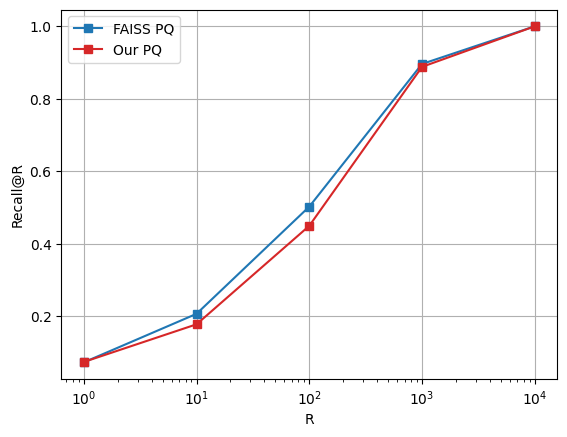

In [32]:
plt.plot(R, faiss_recall_mean, '-s', label="FAISS PQ", color=matplotlib.colormaps["tab20"](0))
plt.plot(R, mine_recall_mean, '-s', label="Our PQ", color=matplotlib.colormaps["tab20"](6))
plt.xscale('log')
plt.xlabel('R')
plt.ylabel('Recall@R')
plt.legend()
plt.grid()

In [33]:
def sorted2rank(sorted):
  ranking = np.zeros(len(sorted))
  for i, el in enumerate(sorted):
      ranking[el] = i+1
  return ranking

In [34]:
kendalls_mine_pq = np.zeros(queries.shape[0])
spearmans_mine_pq = np.zeros(queries.shape[0])

kendalls_faiss_pq = np.zeros(queries.shape[0])
spearmans_faiss_pq = np.zeros(queries.shape[0])

for i in range(queries.shape[0]):
  sorted_exact = sorted2rank(ranks_exact[i])
  sorted_mine_pq = sorted2rank(ranks_mine_pq[i])
  sorted_faiss_pq = sorted2rank(ranks_faiss_pq[i])

  kendalls_mine_pq[i], _ = kendalltau(sorted_mine_pq, sorted_exact)
  spearmans_mine_pq[i], _ = spearmanr(sorted_mine_pq, sorted_exact)

  kendalls_faiss_pq[i], _ = kendalltau(sorted_faiss_pq, sorted_exact)
  spearmans_faiss_pq[i], _ = spearmanr(sorted_faiss_pq, sorted_exact)


pd.DataFrame({
    "Average kendall PQ": [np.mean(kendalls_mine_pq), np.mean(kendalls_faiss_pq)],
    "Average spearman PQ": [np.mean(spearmans_mine_pq), np.mean(spearmans_faiss_pq)],
}, index=["Our", "FAISS"])

,Average kendall PQ,Average spearman PQ
Our,0.388462,0.551508
FAISS,0.392899,0.557155


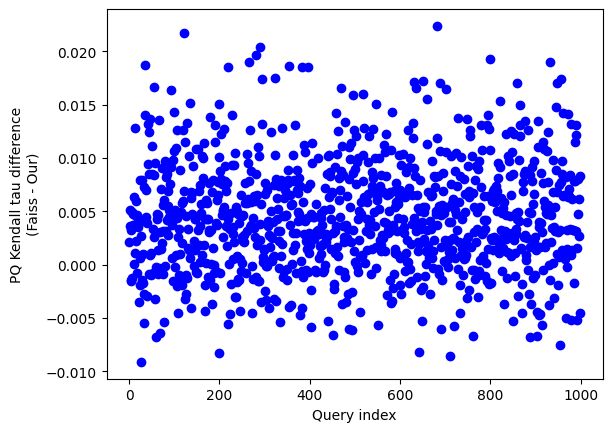

In [35]:
plt.plot(kendalls_faiss_pq-kendalls_mine_pq, 'o', color='blue')
plt.xlabel("Query index")
plt.ylabel("PQ Kendall tau difference\n(Faiss - Our)");